<a href="https://colab.research.google.com/github/UlyShel/basics_of_machine_learning/blob/main/HW5_%D0%A8%D0%B5%D0%BB%D0%B5%D0%B3%D0%BE%D0%B2%D0%B0_%D0%A3%D0%BB%D1%8C%D1%8F%D0%BD%D0%B0_%D0%9E%D0%9C%D0%9E2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Домашнее задание 5. Градиентный спуск. (10 баллов + 2.5 бонус)

В этом домашнем задании вы напишете градиентный спуск для линейной регрессии, а так же посмотрите, как он ведёт себя с разными параметрами и разными функциями потерь.

Правила:

* Домашнее задание оценивается в 10 баллов.

* Можно использовать без доказательства любые результаты, встречавшиеся на лекциях или семинарах по курсу, если получение этих результатов не является вопросом задания.

* Можно использовать любые свободные источники с *обязательным* указанием ссылки на них.

* Плагиат не допускается. При обнаружении случаев списывания, 0 за работу выставляется всем участникам нарушения, даже если можно установить, кто у кого списал.

* Старайтесь сделать код как можно более оптимальным. В частности, будет штрафоваться использование циклов в тех случаях, когда операцию можно совершить при помощи инструментов библиотек, о которых рассказывалось в курсе.  

In [ ]:
from typing import Iterable, List

import matplotlib.pyplot as plt
import numpy as np

## Часть 1. Градиентный спуск (5 баллов)

Для начала давайте вспомним самый простой функционал ошибки, который мы применяем в задаче регрессии — Mean Squared Error:

$$
Q(w, X, y) = \frac{1}{\ell} \sum\limits_{i=1}^\ell (\langle x_i, w \rangle - y_i)^2
$$

где $x_i$ — это $i$-ый объект датасета, $y_i$ — правильный ответ для $i$-го объекта, а $w$ — веса нашей линейной модели.

Как мы помним, для линейной модели, его можно записать в матричном виде вот так:

$$
Q(w, X, y) = \frac{1}{\ell} || Xw - y ||^2
$$

где $X$ — это матрица объекты-признаки, а $y$ — вектор правильных ответов

Для того чтобы воспользоваться методом градиентного спуска, нам нужно посчитать градиент нашего функционала. Для MSE он будет выглядеть так:

$$
\nabla_w Q(w, X, y) = \frac{2}{\ell} X^T(Xw-y)
$$

Ниже приведён базовый класс `BaseLoss`, который мы будем использовать для реализации всех наших лоссов. Менять его не нужно. У него есть два абстрактных метода:
1. Метод `calc_loss`, который будет принимать на вход объекты `x`, правильные ответы `y` и веса `w` и вычислять значения лосса
2. Метод `calc_grad`, который будет принимать на вход объекты `x`, правильные ответы `y` и веса `w` и вычислять значения градиента (вектор)

In [ ]:
import abc


class BaseLoss(abc.ABC):
    """Базовый класс лосса"""

    @abc.abstractmethod
    def calc_loss(self, X: np.ndarray, y: np.ndarray, w: np.ndarray) -> float:
        """
        Функция для вычислений значения лосса
        :param X: np.ndarray размера (n_objects, n_features) с объектами датасета
        :param y: np.ndarray размера (n_objects,) с правильными ответами
        :param w: np.ndarray размера (n_features,) с весами линейной регрессии
        :return: число -- значения функции потерь
        """
        raise NotImplementedError

    @abc.abstractmethod
    def calc_grad(self, X: np.ndarray, y: np.ndarray, w: np.ndarray) -> np.ndarray:
        """
        Функция для вычислений градиента лосса по весам w
        :param X: np.ndarray размера (n_objects, n_features) с объектами датасета
        :param y: np.ndarray размера (n_objects,) с правильными ответами
        :param w: np.ndarray размера (n_features,) с весами линейной регрессии
        :return: np.ndarray размера (n_features,) градиент функции потерь по весам w
        """
        raise NotImplementedError

Теперь давайте напишем реализацию этого абстрактоного класса: Mean Squared Error лосс.

**Задание 1.1 (5/8 балла):** Реализуйте класс `MSELoss`

Он должен вычислять лосс и градиент по формулам наверху

In [ ]:
class MSELoss(BaseLoss):
    def calc_loss(self, X: np.ndarray, y: np.ndarray, w: np.ndarray) -> float:
        """
        Функция для вычислений значения лосса
        :param X: np.ndarray размера (n_objects, n_features) с объектами датасета
        :param y: np.ndarray размера (n_objects,) с правильными ответами
        :param w: np.ndarray размера (n_features,) с весами линейной регрессии
        :return: число -- значения функции потерь
        """
        return np.sum((np.dot(X, w) - y)**2)/len(y)

    def calc_grad(self, X: np.ndarray, y: np.ndarray, w: np.ndarray) -> np.ndarray:
        """
        Функция для вычислений градиента лосса по весам w
        :param X: np.ndarray размера (n_objects, n_features) с объектами датасета
        :param y: np.ndarray размера (n_objects,) с правильными ответами
        :param w: np.ndarray размера (n_features,) с весами линейной регрессии
        :return: np.ndarray размера (n_features,) градиент функции потерь по весам w
        """
        return (2 * np.dot(np.transpose(X),(np.dot(X, w) - y))) / y.shape[0]

Теперь мы можем создать объект `MSELoss` и при помощи него вычислять значение нашей функции потерь и градиенты:

In [ ]:
# Создадим объект лосса
loss = MSELoss()

# Создадим какой-то датасет
X = np.arange(200).reshape(20, 10)
y = np.arange(20)

# Создадим какой-то вектор весов
w = np.arange(10)

# Выведем значение лосса и градиента на этом датасете с этим вектором весов
print(loss.calc_loss(X, y, w))
print(loss.calc_grad(X, y, w))

# Проверка, что методы реализованы правильно
assert loss.calc_loss(X, y, w) == 27410283.5, "Метод calc_loss реализован неверно"
assert np.allclose(
    loss.calc_grad(X, y, w),
    np.array(
        [
            1163180.0,
            1172281.0,
            1181382.0,
            1190483.0,
            1199584.0,
            1208685.0,
            1217786.0,
            1226887.0,
            1235988.0,
            1245089.0,
        ]
    ),
), "Метод calc_grad реализован неверно"
print("Всё верно!")

27410283.5
[1163180. 1172281. 1181382. 1190483. 1199584. 1208685. 1217786. 1226887.
 1235988. 1245089.]
Всё верно!


Теперь когда у нас есть всё для вычисления градиента, давайте напишем наш градиентный спуск. Напомним, что формула для одной итерации градиентного спуска выглядит следующим образом:

$$
w^t = w^{t-1} - \eta \nabla_{w} Q(w^{t-1}, X, y)
$$

Где $w^t$ — значение вектора весов на $t$-ой итерации, а $\eta$ — параметр learning rate, отвечающий за размер шага.

**Задание 1.2 (5/8 балла):** Реализуйте функцию `gradient_descent`

Функция должна принимать на вход начальное значение весов линейной модели `w_init`, матрицу объектов-признаков `X`,
вектор правильных ответов `y`, объект функции потерь `loss`, размер шага `lr` и количество итераций `n_iterations`.

Функция должна реализовывать цикл, в котором происходит шаг градиентного спуска (градиенты берутся из `loss` посредством вызова метода `calc_grad`) по формуле выше и возвращать
траекторию спуска (список из новых значений весов на каждом шаге)

In [ ]:
def gradient_descent(
    w_init: np.ndarray,
    X: np.ndarray,
    y: np.ndarray,
    loss: BaseLoss,
    lr: float,
    n_iterations: int = 100000,
) -> List[np.ndarray]:
    """
    Функция градиентного спуска
    :param w_init: np.ndarray размера (n_feratures,) -- начальное значение вектора весов
    :param X: np.ndarray размера (n_objects, n_features) -- матрица объекты-признаки
    :param y: np.ndarray размера (n_objects,) -- вектор правильных ответов
    :param loss: Объект подкласса BaseLoss, который умеет считать градиенты при помощи loss.calc_grad(X, y, w)
    :param lr: float -- параметр величины шага, на который нужно домножать градиент
    :param n_iterations: int -- сколько итераций делать
    :return: Список из n_iterations объектов np.ndarray размера (n_features,) -- история весов на каждом шаге
    """

    w = w_init.copy()
    w_list = [w.copy()]

    losss = MSELoss()

    for step in range(n_iterations):

      gradient = losss.calc_grad(X, y, w)
      w = w - lr * gradient
      w_list.append(w.copy())

    return np.array(w_list)

Теперь создадим синтетический датасет и функцию, которая будет рисовать траекторию градиентного спуска по истории:

In [ ]:
# Создаём датасет из двух переменных и реального вектора зависимости w_true

np.random.seed(1337)

n_features = 2
n_objects = 300
batch_size = 10
num_steps = 43

w_true = np.random.normal(size=(n_features,))

X = np.random.uniform(-5, 5, (n_objects, n_features))
X *= (np.arange(n_features) * 2 + 1)[np.newaxis, :]
y = X.dot(w_true) + np.random.normal(0, 1, (n_objects))
w_init = np.random.uniform(-2, 2, (n_features))

print(X.shape)
print(y.shape)

(300, 2)
(300,)


In [ ]:
loss = MSELoss()
w_list = gradient_descent(w_init, X, y, loss, 0.01, 100)
print(loss.calc_loss(X, y, w_list[0]))
print(loss.calc_loss(X, y, w_list[-1]))

425.58917680450253
0.8670644395649493


In [ ]:
def plot_gd(w_list: Iterable, X: np.ndarray, y: np.ndarray, loss: BaseLoss):
    """
    Функция для отрисовки траектории градиентного спуска
    :param w_list: Список из объектов np.ndarray размера (n_features,) -- история весов на каждом шаге
    :param X: np.ndarray размера (n_objects, n_features) -- матрица объекты-признаки
    :param y: np.ndarray размера (n_objects,) -- вектор правильных ответов
    :param loss: Объект подкласса BaseLoss, который умеет считать лосс при помощи loss.calc_loss(X, y, w)
    """
    w_list = np.array(w_list)
    meshgrid_space = np.linspace(-2, 2, 100)
    A, B = np.meshgrid(meshgrid_space, meshgrid_space)

    levels = np.empty_like(A)
    for i in range(A.shape[0]):
        for j in range(A.shape[1]):
            w_tmp = np.array([A[i, j], B[i, j]])
            levels[i, j] = loss.calc_loss(X, y, w_tmp)

    plt.figure(figsize=(15, 6))
    plt.title("GD trajectory")
    plt.xlabel(r"$w_1$")
    plt.ylabel(r"$w_2$")
    plt.xlim(w_list[:, 0].min() - 0.1, w_list[:, 0].max() + 0.1)
    plt.ylim(w_list[:, 1].min() - 0.1, w_list[:, 1].max() + 0.1)
    plt.gca().set_aspect("equal")

    # visualize the level set
    CS = plt.contour(
        A, B, levels, levels=np.logspace(0, 1, num=20), cmap=plt.cm.rainbow_r
    )
    CB = plt.colorbar(CS, shrink=0.8, extend="both")

    # visualize trajectory
    plt.scatter(w_list[:, 0], w_list[:, 1])
    plt.plot(w_list[:, 0], w_list[:, 1])

    plt.show()

**Задание 1.3 (5/8 балла):** При помощи функций `gradient_descent` и  `plot_gd` нарисуйте траекторию градиентного спуска для разных значений длины шага (параметра `lr`). Используйте не менее четырёх разных значений для `lr`.

Сделайте и опишите свои выводы о том, как параметр `lr` влияет на поведение градиентного спуска

Подсказки:
* Функция `gradient_descent` возвращает историю весов, которую нужно подать в функцию `plot_gd`
* Хорошие значения для `lr` могут лежать в промежутке от 0.0001 до 0.1

In [ ]:
# lr_all = np.random.uniform(low=0.0001, high=0.1, size=(4, ))
# lr_all_List = list(lr_all)

# for step in lr_all_List:
#   grad = gradient_descent(w_init, X, y, loss, step, 100)
#   plot_gd(grad, X, y, loss)

Сначала планировала делать, так, как написано в ячейке выше, но поняла, что рандом может прийтись и на довольно близкие значения, поэтому...

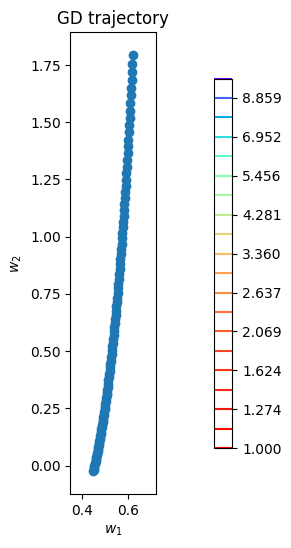

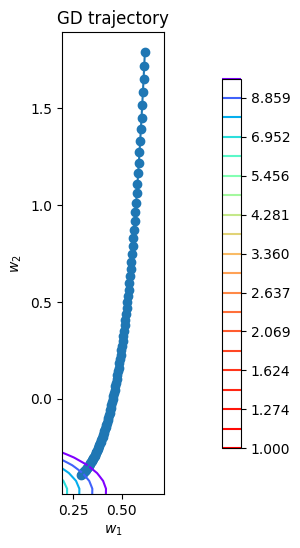

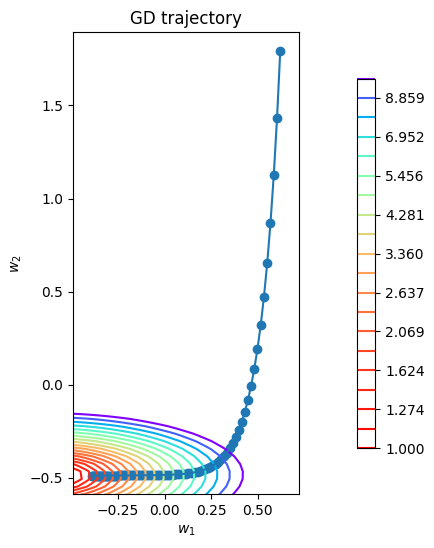

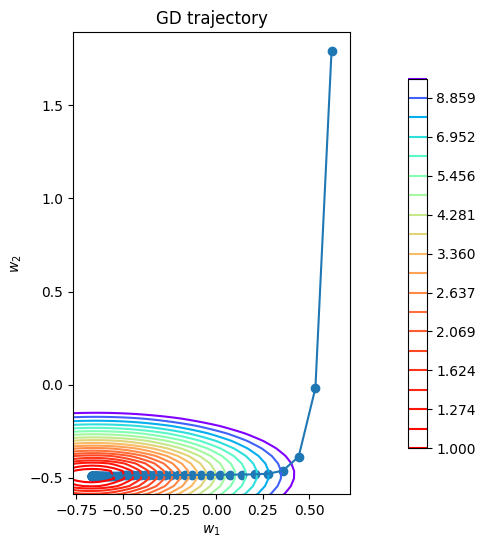

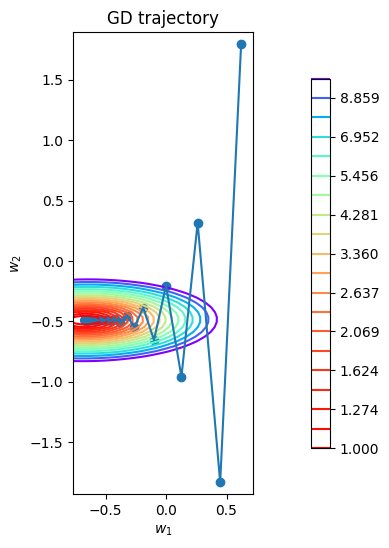

In [ ]:
lr_all_List = [0.0001, 0.0002, 0.001, 0.005, 0.01]
for step in lr_all_List:
  grad = gradient_descent(w_init, X, y, loss, step, 100)
  plot_gd(grad, X, y, loss)

Длина шага позволяет регулировать скорость, с которой мы придем к точке минимума (и возможность придти к ней в принципе, потому что в случае слишком маленького шага - в диапазоне от от 0.0001 до 0.001 - мы до него не доходим!). Тем не менее, это так же во многом зависит от количества шагов. Так, если мы поставим, 1000, то мы в итоге дойдем до минимума, но тут возможны другие нюансы - переобучение, затрата памяти и времени.

В нашем случае - самый хороший шаг это 0.01 (бОльшие скачки) или 0.005 (более равномерно), нет переобучения, при этом мы более-менее попадаем в точку минимума!

Теперь реализуем стохастический градиентный спуск

**Задание 1.4 (5/8 балла):** Реализуйте функцию `stochastic_gradient_descent`

Функция должна принимать все те же параметры, что и функция `gradient_descent`, но ещё параметр `batch_size`, отвечающий за размер батча.

Функция должна как и раньше реализовывать цикл, в котором происходит шаг градиентного спуска, но на каждом шаге считать градиент не по всей выборке `X`, а только по случайно выбранной части.

Подсказка: для выбора случайной части можно использовать [`np.random.choice`](https://numpy.org/doc/stable/reference/random/generated/numpy.random.choice.html) с правильным параметром `size`, чтобы выбрать случайные индексы, а потом проиндексировать получившимся массивом массив `X`:
```
batch_indices = np.random.choice(X.shape[0], size=batch_size, replace=False)
batch = X[batch_indices]
```

In [ ]:
from logging import logProcesses
def stochastic_gradient_descent(
    w_init: np.ndarray,
    X: np.ndarray,
    y: np.ndarray,
    loss: BaseLoss,
    lr: float,
    batch_size: int,
    n_iterations: int = 1000,
) -> List[np.ndarray]:
    """
    Функция градиентного спуска
    :param w_init: np.ndarray размера (n_feratures,) -- начальное значение вектора весов
    :param X: np.ndarray размера (n_objects, n_features) -- матрица объекты-признаки
    :param y: np.ndarray размера (n_objects,) -- вектор правильных ответов
    :param loss: Объект подкласса BaseLoss, который умеет считать градиенты при помощи loss.calc_grad(X, y, w)
    :param lr: float -- параметр величины шага, на который нужно домножать градиент
    :param batch_size: int -- размер подвыборки, которую нужно семплировать на каждом шаге
    :param n_iterations: int -- сколько итераций делать
    :return: Список из n_iterations объектов np.ndarray размера (n_features,) -- история весов на каждом шаге
    """
    w = w_init.copy()
    w_list = [w.copy()]

    for step in range(n_iterations):

      batch_indices = np.random.choice(X.shape[0], size=batch_size, replace=False)
      batch_X = X[batch_indices]
      batch_y = y[batch_indices]

      st_gradient = (2 * np.dot(batch_X.T, (np.dot(batch_X, w) - batch_y))) / batch_size

      w -= lr * st_gradient
      w_list.append(w.copy())

    return np.array(w_list)

**Задание 1.5 (5/8 балла):** При помощи функций `stochastic_gradient_descent` и  `plot_gd` нарисуйте траекторию градиентного спуска для разных значений длины шага (параметра `lr`) и размера подвыборки (параметра `batch_size`). Используйте не менее четырёх разных значений для `lr` и `batch_size`.

Сделайте и опишите свои выводы о том, как параметры  `lr` и `batch_size` влияют на поведение стохастического градиентного спуска. Как отличается поведение стохастического градиентного спуска от обычного?

Обратите внимание, что в нашем датасете всего 300 объектов, так что `batch_size` больше этого числа не будет иметь смысла.

Длина шага: 0.0001, Размер подвыборки: 50


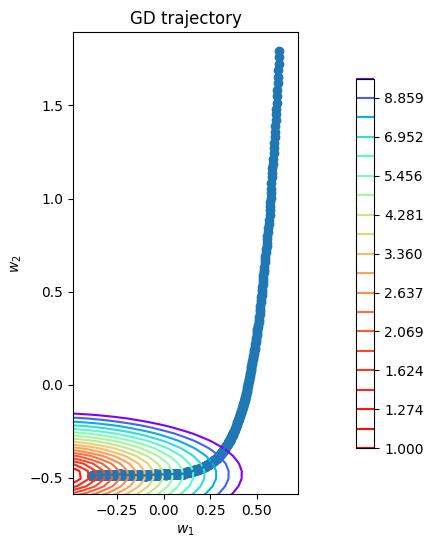

Длина шага: 0.0001, Размер подвыборки: 100


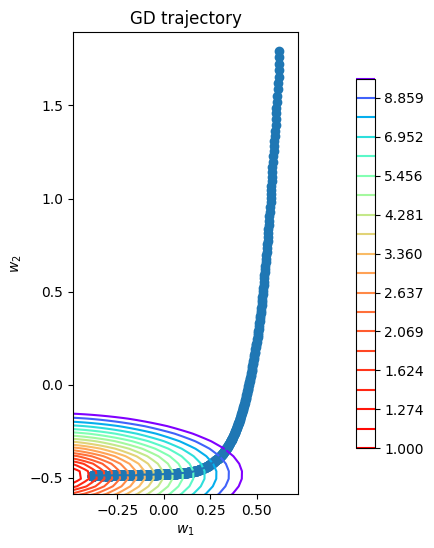

Длина шага: 0.0001, Размер подвыборки: 150


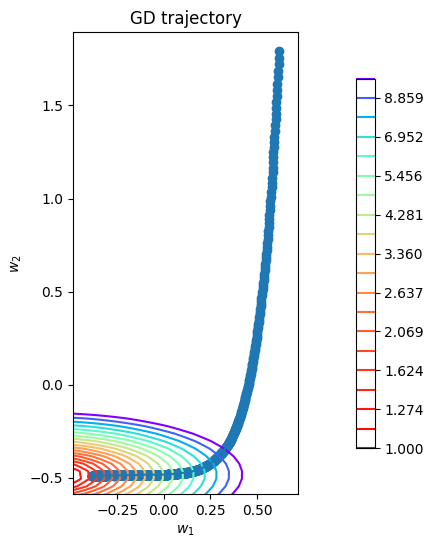

Длина шага: 0.0001, Размер подвыборки: 200


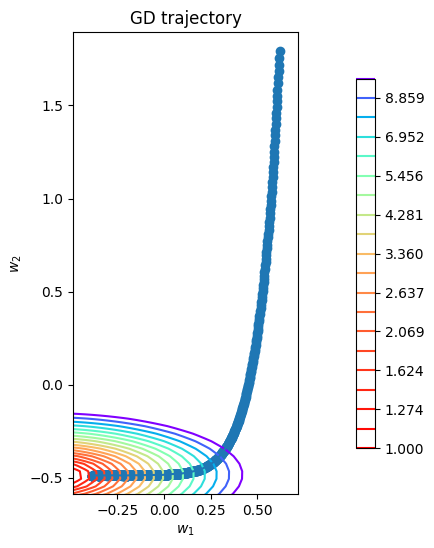

Длина шага: 0.0003, Размер подвыборки: 50


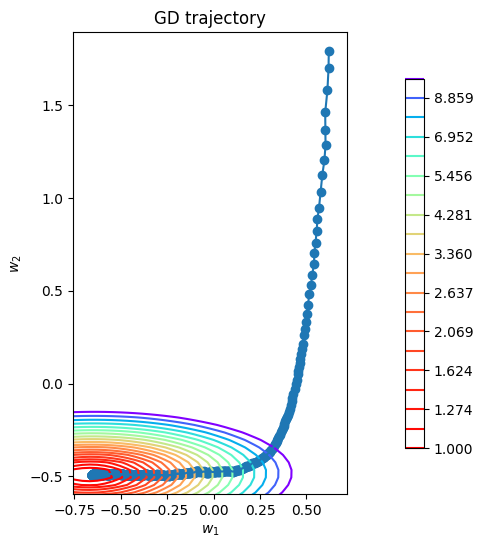

Длина шага: 0.0003, Размер подвыборки: 100


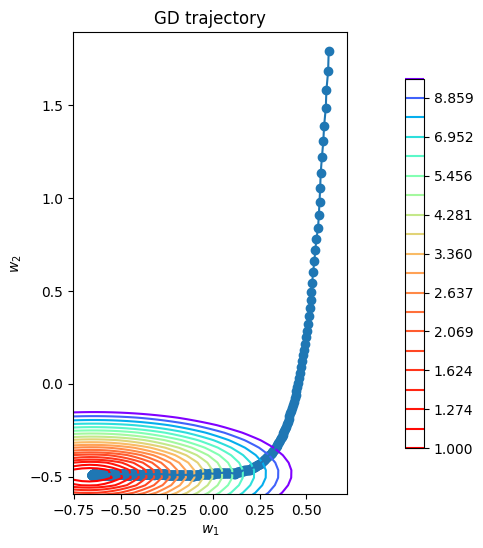

Длина шага: 0.0003, Размер подвыборки: 150


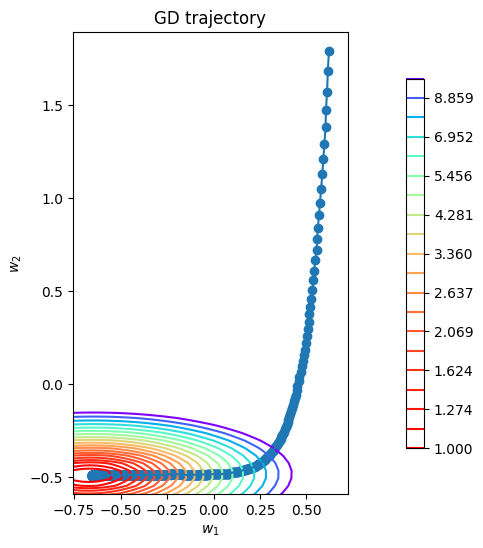

Длина шага: 0.0003, Размер подвыборки: 200


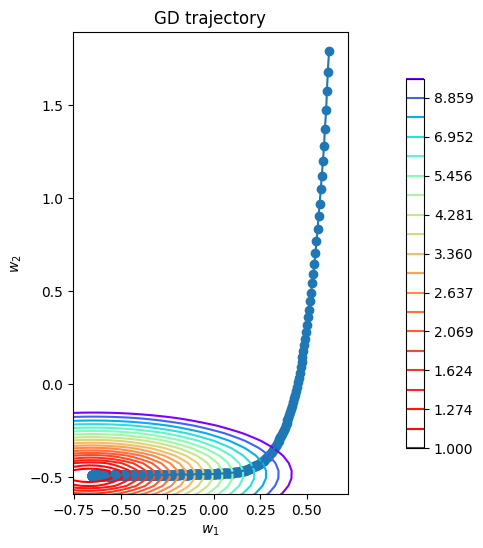

Длина шага: 0.005, Размер подвыборки: 50


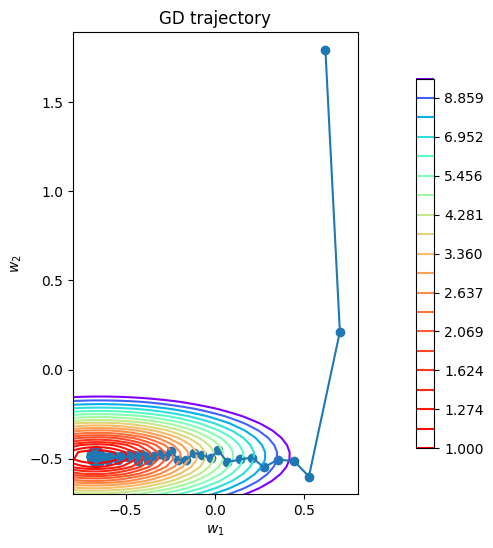

Длина шага: 0.005, Размер подвыборки: 100


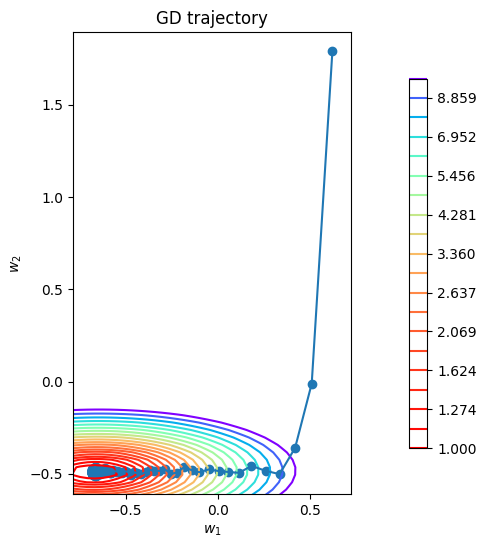

Длина шага: 0.005, Размер подвыборки: 150


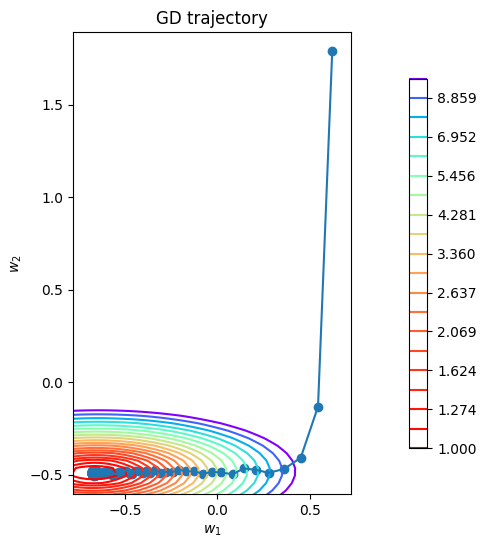

Длина шага: 0.005, Размер подвыборки: 200


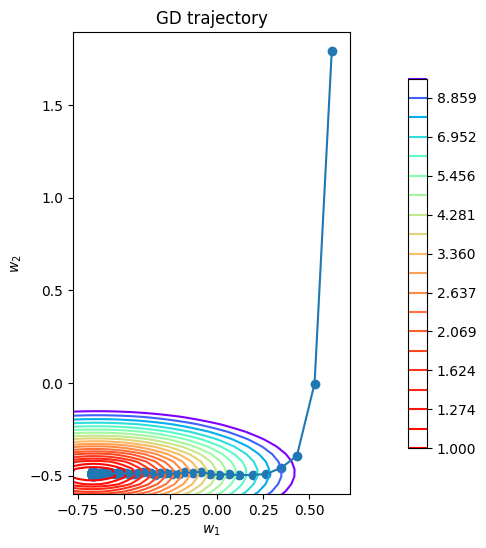

Длина шага: 0.008, Размер подвыборки: 50


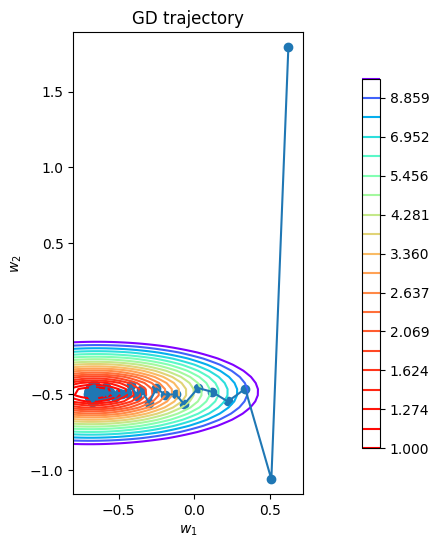

Длина шага: 0.008, Размер подвыборки: 100


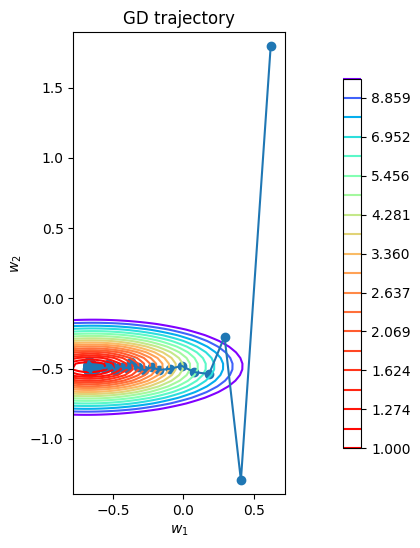

Длина шага: 0.008, Размер подвыборки: 150


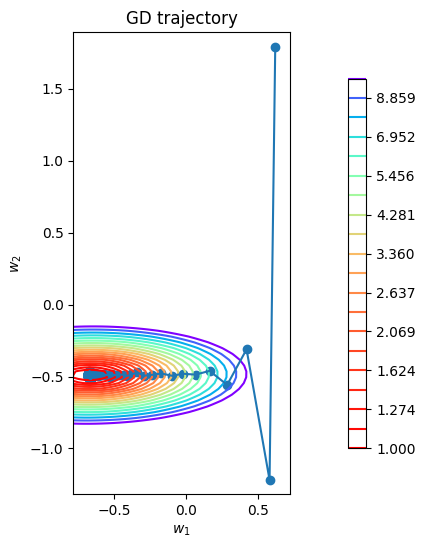

Длина шага: 0.008, Размер подвыборки: 200


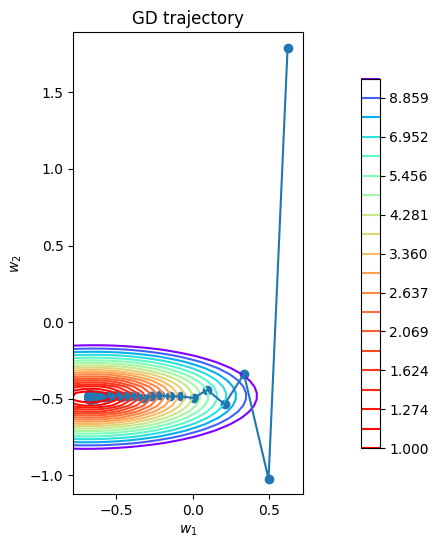

In [ ]:
lr_stochastic = [0.0001, 0.0003, 0.005, 0.008]
all_batch = [50, 100, 150, 200]
for step in lr_stochastic:
  for batch in all_batch:
    grad = stochastic_gradient_descent(w_init, X, y, loss, step, batch, 1000)
    print(f"Длина шага: {step}, Размер подвыборки: {batch}")
    plot_gd(grad, X, y, loss)

Вы могли заметить, что поведение градиентного спуска, особенно стохастической версии, очень сильно зависит от размера шага.

Как правило, в начале спуска мы хотим делать большие шаги, чтобы поскорее подойти поближе к минимуму, а позже мы уже хотим делать шаги маленькие, чтобы более точнее этого минимума достичь и не "перепрыгнуть" его.

Чтобы достичь такого поведения мы можем постепенно уменьшать длину шага с увеличением номера итерации. Сделать это можно, например, вычисляя на каждой итерации длину шага по следующей формуле:

$$
    \eta_t
    =
    \lambda
    \left(
        \frac{s_0}{s_0 + t}
    \right)^p
$$

где $\eta_t$ — длина шага на итерации $t$, $\lambda$ — начальная длина шага (параметр `lr` у нас), $s_0$ и $p$ — настраиваемые параметры.

**Задание 1.6 (5/8 балла):** Реализуйте функцию `stochastic_gradient_descent` на этот раз с затухающим шагом по формуле выше. Параметр $s_0$ возьмите равным 1. Параметр $p$ возьмите из нового аргумента функции `p`.

In [ ]:
def stochastic_gradient_descent2(
    w_init: np.ndarray,
    X: np.ndarray,
    y: np.ndarray,
    loss: BaseLoss,
    lr: float,
    batch_size: int,
    p: float,
    n_iterations: int = 1000,
) -> List[np.ndarray]:
    """
    Функция градиентного спуска
    :param w_init: np.ndarray размера (n_feratures,) -- начальное значение вектора весов
    :param X: np.ndarray размера (n_objects, n_features) -- матрица объекты-признаки
    :param y: np.ndarray размера (n_objects,) -- вектор правильных ответов
    :param loss: Объект подкласса BaseLoss, который умеет считать градиенты при помощи loss.calc_grad(X, y, w)
    :param lr: float -- параметр величины шага, на который нужно домножать градиент
    :param batch_size: int -- размер подвыборки, которую нужно семплировать на каждом шаге
    :param p: float -- значение степени в формуле затухания длины шага
    :param n_iterations: int -- сколько итераций делать
    :return: Список из n_iterations объектов np.ndarray размера (n_features,) -- история весов на каждом шаге
    """
    w = w_init.copy()
    w_list = [w.copy()]

    s_init = 1.0

    for step in range(n_iterations):

      batch_indices = np.random.choice(X.shape[0], size=batch_size, replace=False)
      batch_X = X[batch_indices]
      batch_y = y[batch_indices]

      st_gradient = 2 * np.dot(batch_X.T, np.dot(batch_X, w) - batch_y) / batch_size

      step_size = lr * np.power(s_init / (s_init + step), p)

      w -= step_size * st_gradient
      w_list.append(w.copy())

    return np.array(w_list)

**Задание 1.7 (5/8 балла):** При помощи новой функции `stochastic_gradient_descent` и функции `plot_gd` нарисуйте траекторию градиентного спуска для разных значений параметра `p`. Используйте не менее четырёх разных значений для `p`. Хорошими могут быть значения, лежащие в промежутке от 0.1 до 1.
Параметр `lr` возьмите равным 0.01, а параметр `batch_size` равным 10.

Сделайте и опишите свои выводы о том, как параметр `p` влияет на поведение стохастического градиентного спуска

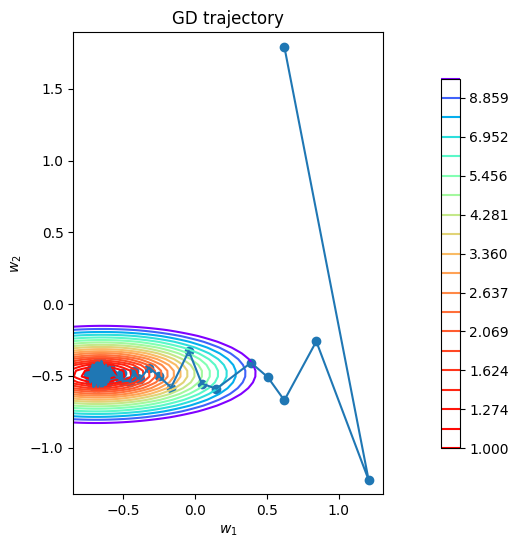

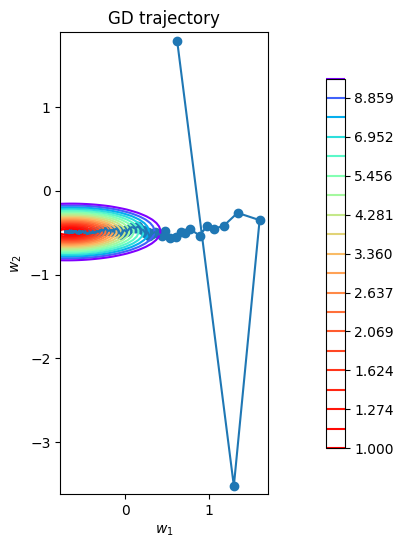

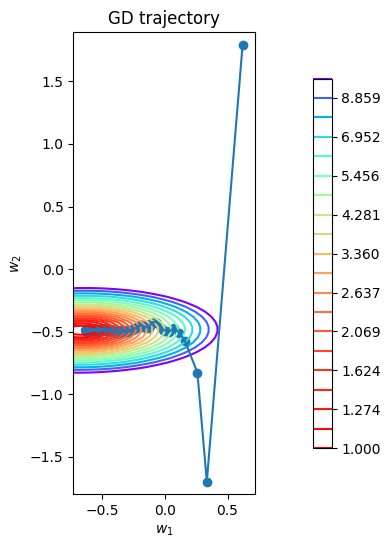

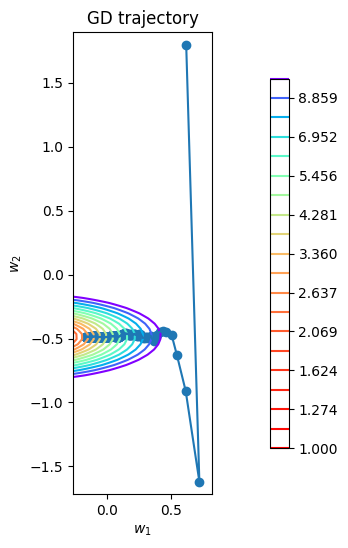

In [ ]:
p_all = [0.1, 0.5, 0.7, 1]

for p_val in p_all:
  grad = stochastic_gradient_descent2(w_init, X, y, loss, 0.01, 10, p_val, 1000)
  plot_gd(grad, X, y, loss)

Параметр p позволяет контролировать скорость уменьшения шага градиентного спуска, и это важно для того, чтобы мы в целом попали в точку минимума. В стохастическом градиентном спуске в действиельности может быть такая проблема, что шаг уменьшается насколько, что колебания становятся незначительными, заставляя нас остановиться, например, на середине.

На последнем графике мы установили наиболее высокую скорость затухания шага, и мы как раз видим реализацию того, о чем мы говорим выше. Мы не попадаем в точку минимума.

При этом при слишком маленьком параметре p мы теряем смысл использования уменьшения шага, потому что наш график так же сильно шатает, как и при использовании стохастического градиентного спуска.

Оптимальными кажутся градиенты при параметре p = 0.5 или 0.7. График меньше шатает, ну и точка минимума достигнута.

**Задание 1.8 (5/8 балла):** Сравните сходимость обычного градиентного спуска и стохастичекой версии:
Нарисуйте график зависимости значения лосса (его можно посчитать при помощи метода `calc_loss`, используя $x$ и $y$ из датасета и $w$ с соответствующей итерации) от номера итерации для траекторий, полученных при помощи обычного и стохастического градиентного спуска с одинаковыми параметрами. Параметр `batch_size` возьмите равным 10.

Видно ли на данном графике преимущество SGD? Почему?

In [ ]:
all_losses_gd = []
loss = MSELoss()
w_list_gd = gradient_descent(w_init, X, y, loss, 0.01, 600)
for w in list(w_list_gd):
  all_losses_gd.append(loss.calc_loss(X, y, w))

In [ ]:
all_losses_st_gd = []
w_list_st_gd = stochastic_gradient_descent(w_init, X, y, loss, 0.01, 10, 600)
for w in list(w_list_st_gd):
  all_losses_st_gd.append(loss.calc_loss(X, y, w))

In [ ]:
all_losses_st_gd2 = []
w_list_st_gd2 = stochastic_gradient_descent2(w_init, X, y, loss, 0.01, 10, 1, 600)
for w in list(w_list_st_gd2):
  all_losses_st_gd2.append(loss.calc_loss(X, y, w))

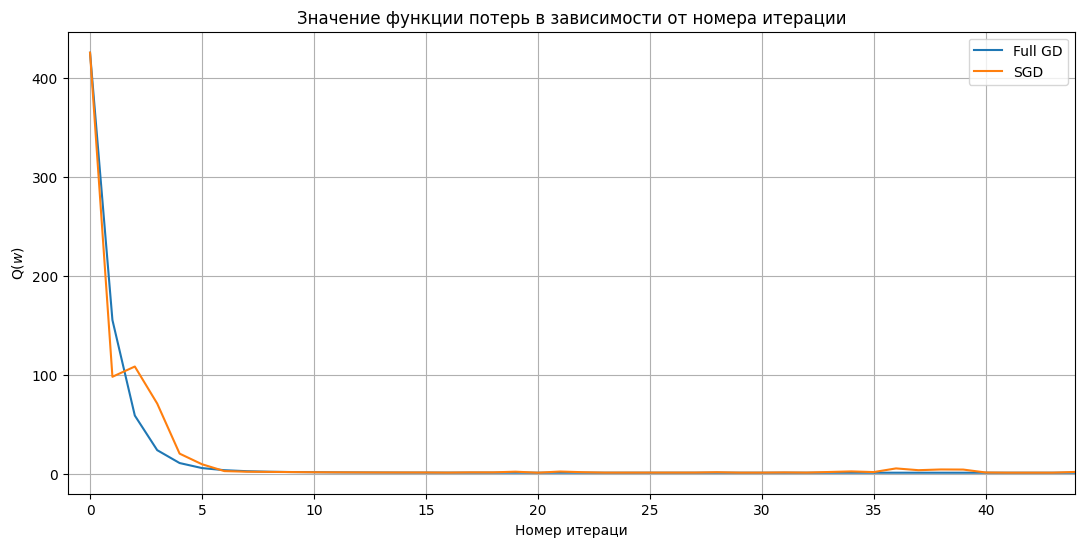

In [ ]:
steps = 601

plt.figure(figsize=(13, 6))
plt.plot(np.arange(steps), all_losses_gd, label="Full GD")
plt.plot(np.arange(steps), all_losses_st_gd, label="SGD")

plt.title("Значение функции потерь в зависимости от номера итерации")
plt.xlim((-1, num_steps + 1))
plt.legend()
plt.xlabel("Номер итераци")
plt.ylabel(r"Q($w$)")
plt.grid()
plt.show()

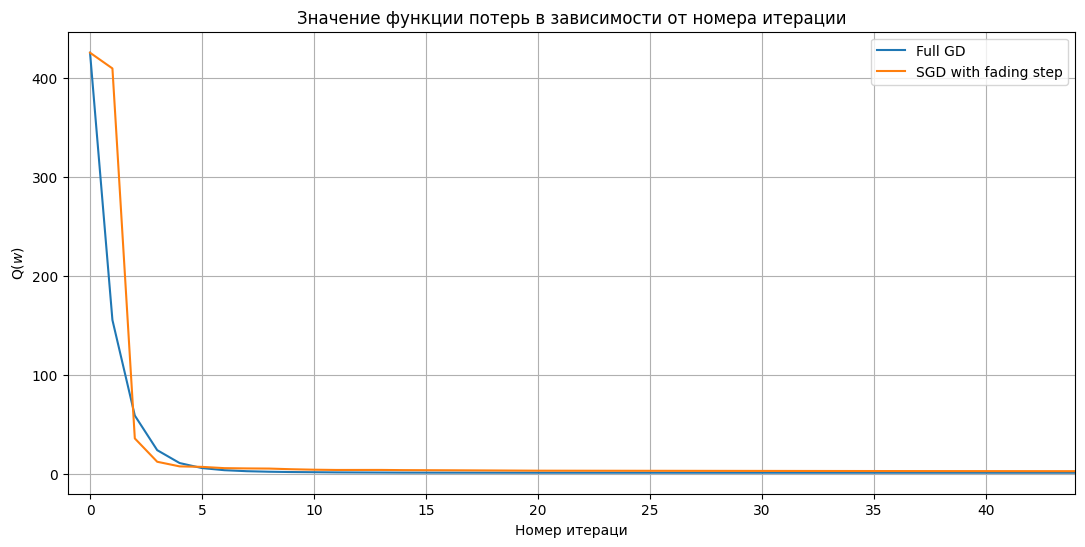

In [ ]:
steps = 601

plt.figure(figsize=(13, 6))
plt.plot(np.arange(steps), all_losses_gd, label="Full GD")
plt.plot(np.arange(steps), all_losses_st_gd2, label='SGD with fading step')

plt.title("Значение функции потерь в зависимости от номера итерации")
plt.xlim((-1, num_steps + 1))
plt.legend()
plt.xlabel("Номер итераци")
plt.ylabel(r"Q($w$)")
plt.grid()
plt.show()

Видно, что за затухающий шаг работает лучше, заметно сглаживая колебания, которые в стохастическом градиентом спуске встречаются не только в начале, но и под конец, если взять малое количество шагов (например, в нашем случае - меньше 1000). Но, конечно, под конец все графики примерно приходят в точку минимума, но совсем малое количество шагов (меньше 600) может привести к тому, что стохастический градиентный спуск с затухающим шагом не приходит в точку минимума функции.

На самой картинке плюсы не видны, потому что основная проблема классического градиентного спуска, которую мы минуем, прибегая к стохастическому градиентному спуску - долгий подсчет всех градиентов для каждой точки каждого объекта. Здесь же мы видим, что с точки зрения количества итераций GD быстрее приходит к минимуму, хотя скорость выполнения одной итерации и может быть значительно больше.

## Часть 2. Линейная регрессия (5 баллов)

Теперь давайте напишем наш класс для линейной регрессии. Он будет использовать интерфейс, знакомый нам из библиотеки `sklearn`.

В методе `fit` мы будем подбирать веса `w` при помощи градиентного спуска нашим методом `gradient_descent`

В методе `predict` мы будем применять нашу регрессию к датасету,

**Задание 2.1 (5/8 балла):** Допишите код в методах `fit` и `predict` класса `LinearRegression`

В методе `fit` вам нужно как-то инициализировать веса `w`, применить `gradient_descent` и сохранить последнюю `w` из траектории.

В методе `predict` вам нужно применить линейную регрессию и вернуть вектор ответов.

Обратите внимание, что объект лосса передаётся в момент инициализации и хранится в `self.loss`. Его нужно использовать в `fit` для `gradient_descent`.

In [ ]:
class LinearRegression:
    def __init__(self, loss: BaseLoss, lr: float = 0.1) -> None:
        self.loss = loss
        self.lr = lr

    def fit(self, X: np.ndarray, y: np.ndarray) -> "LinearRegression":
        X = np.asarray(X)
        y = np.asarray(y)

        # Добавляем столбец из единиц для константного признака
        X = np.hstack([X, np.ones([X.shape[0], 1])])

        self.w = np.random.uniform(-2, 2, (X.shape[1]))
        self.w = gradient_descent(self.w, X, y, self.loss, self.lr, 10000)

        self.w_last = self.w[-1]

        return self.w_last

    def predict(self, X: np.ndarray) -> np.ndarray:
        # Проверяем, что регрессия обучена, то есть, что был вызван fit и в нём был установлен атрибут self.w
        assert hasattr(self, "w"), "Linear regression must be fitted first"
        # Добавляем столбец из единиц для константного признака
        X = np.asarray(X)
        X = np.hstack([X, np.ones([X.shape[0], 1])])
        pred = np.dot(np.expand_dims(self.w_last, axis=0), np.transpose(X))

        return pred

Теперь у нас есть наш класс линейной регрессии. Более того, мы можем управлять тем, какую функцию потерь мы оптимизируем, просто передавая разные классы в параметр `loss` при инициализации.

Пока у нас нет никаких классов кроме `MSELoss`, но скоро они появятся.

Для `MSELoss` мы бы создавали наш объект линейной регрессии, например, так:

In [ ]:
linear_regression = LinearRegression(MSELoss(), lr=0.1)

Применим нашу регрессию на реальном датасете. Загрузим датасет с машинами, который был у вас на семинарах:

In [ ]:
import pandas as pd

X_raw = pd.read_csv(
    "http://archive.ics.uci.edu/ml/machine-learning-databases/autos/imports-85.data",
    header=None,
    na_values=["?"],
)
X_raw.head()
X_raw = X_raw[~X_raw[25].isna()].reset_index()

In [ ]:
y = X_raw[25]
X_raw = X_raw.drop(25, axis=1)

In [ ]:
X_raw

,index,0,1,2,3,4,5,6,7,8,...,15,16,17,18,19,20,21,22,23,24
0,0,3,NaN,alfa-romero,gas,std,two,convertible,rwd,front,...,four,130,mpfi,3.47,2.68,9.0,111.0,5000.0,21,27
1,1,3,NaN,alfa-romero,gas,std,two,convertible,rwd,front,...,four,130,mpfi,3.47,2.68,9.0,111.0,5000.0,21,27
2,2,1,NaN,alfa-romero,gas,std,two,hatchback,rwd,front,...,six,152,mpfi,2.68,3.47,9.0,154.0,5000.0,19,26
3,3,2,164.0,audi,gas,std,four,sedan,fwd,front,...,four,109,mpfi,3.19,3.40,10.0,102.0,5500.0,24,30
4,4,2,164.0,audi,gas,std,four,sedan,4wd,front,...,five,136,mpfi,3.19,3.40,8.0,115.0,5500.0,18,22
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
196,200,-1,95.0,volvo,gas,std,four,sedan,rwd,front,...,four,141,mpfi,3.78,3.15,9.5,114.0,5400.0,23,28
197,201,-1,95.0,volvo,gas,turbo,four,sedan,rwd,front,...,four,141,mpfi,3.78,3.15,8.7,160.0,5300.0,19,25
198,202,-1,95.0,volvo,gas,std,four,sedan,rwd,front,...,six,173,mpfi,3.58,2.87,8.8,134.0,5500.0,18,23
199,203,-1,95.0,volvo,diesel,turbo,four,sedan,rwd,front,...,six,145,idi,3.01,3.40,23.0,106.0,4800.0,26,27


In [ ]:
X_raw = X_raw.drop('index', axis=1)

**Задание 2.2 (5/8 балла):** Как обычно обработайте датасет всеми нужными методами, чтобы на нём можно было обучать линейную регрессию:

* Разделите датасет на обучающую и тестовую выборку
* Заполните пропуски
* Нормализуйте числовые признаки
* Закодируйте категориальные переменные

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler

In [ ]:
categ_feat = (X_raw.dtypes=='object').values

X_num = X_raw[X_raw.columns[~categ_feat]]

imp = SimpleImputer(strategy='mean')

X_num.columns = X_num.columns.astype(str)

X_num_new = imp.fit_transform(X_num)
X_numeric = pd.DataFrame(data=X_num_new, columns=X_num.columns)

In [ ]:
X_cat = X_raw[X_raw.columns[categ_feat]].fillna('')

In [ ]:
X_dum = pd.get_dummies(X_cat, drop_first=True, dtype=float)

In [ ]:
normalizer = MinMaxScaler()
X_num_norm = normalizer.fit_transform(X_numeric)
X_num_norm = pd.DataFrame(data=X_num_norm)

In [ ]:
X_num_norm_ind = X_num_norm.reset_index(drop=True)
X_dum_ind = X_dum.reset_index(drop=True)
X_num_cat = pd.concat([X_num_norm_ind, X_dum_ind], axis=1)

In [ ]:
np.random.seed(66)
X_train, X_test, y_train, y_test = train_test_split(X_num_cat, y, test_size=0.3)

**Задание 2.3 (5/8 балла):** Обучите написанную вами линейную регрессию на обучающей выборке

In [ ]:
linear_regression.fit(X_train, y_train)

array([-1.80176916e+03, -5.28015903e+03,  6.56696231e+03, -3.03959462e+03,
        7.60023353e+03, -3.60853059e+03,  1.29926433e+04,  1.67381159e+04,
       -5.51220786e+03, -3.04773600e+03, -5.07479316e+03,  3.67523793e+03,
        3.95414651e+03,  3.19913933e+01,  3.79662135e+03,  5.20937978e+03,
        7.84822065e+03, -1.75795778e+00, -2.89521376e+03, -1.33506357e+03,
       -2.72763701e+03,  2.49154499e+03, -5.08174159e+02,  4.62197512e+03,
        1.66615484e+00, -2.54091857e+03, -1.17211486e+03, -1.34995610e+03,
       -3.82333977e+03,  6.00467434e+03, -1.84880041e+03,  3.25611005e+03,
       -3.55472052e+03, -3.11417207e+03, -7.85197413e+02, -2.70625625e+03,
        1.99656773e+03,  1.70841996e+03,  2.52445329e+02,  9.59322452e+02,
       -2.29108770e+03, -3.01911785e+03, -2.90868465e+03, -3.22162842e+03,
       -1.30841983e+03,  8.07417132e+02,  5.87674513e+03, -1.34659391e+03,
        7.96367235e+02,  2.31956141e+03, -1.92077158e+03,  2.37570849e+02,
       -8.50922732e+03, -

**Задание 2.4 (5/8 балла):** Посчитайте ошибку обученной регрессии на обучающей и тестовой выборке при помощи метода `mean_squared_error` из `sklearn.metrics`.

In [ ]:
from sklearn.metrics import mean_squared_error

In [ ]:
y_predicted = linear_regression.predict(X_train)

In [ ]:
y_predicted = y_predicted.reshape(140,)
y_train.reset_index(drop=True, inplace=True)

In [ ]:
mean_squared_error(y_train, y_predicted)

2338799.2176999873

In [ ]:
y_predicted_test = linear_regression.predict(X_test)
y_predicted_test = y_predicted_test.reshape(61,)

In [ ]:
mean_squared_error(y_test, y_predicted_test)

3688580.416825193

Наша модель переобучилась. Давайте как обычно в такой ситуации добавим к ней L2 регуляризацию. Для этого нам нужно написать новый класс лосса.

Формула функции потерь для MSE с L2 регуляризацией выглядит так:
$$
Q(w, X, y) = \frac{1}{\ell} \sum\limits_{i=1}^\ell (\langle x_i, w \rangle - y_i)^2 + \lambda ||w||^2
$$

Или в матричном виде:

$$
Q(w, X, y) = \frac{1}{\ell} || Xw - y ||^2 + \lambda ||w||^2
$$

Где $\lambda$ — коэффициент регуляризации

Градиент выглядит так:

$$
\nabla_w Q(w, X, y) = \frac{2}{\ell} X^T(Xw-y) + 2 \lambda w
$$

**Задание 2.5 (5/8 балла):** Реализуйте класс `MSEL2Loss`

Он должен вычислять лосс и градиент по формулам наверху

Подсказка: обратите внимание, что последний элемент вектора `w` — это bias (в классе `LinearRegression` к матрице `X` добавляется колонка из единиц — константный признак). Как мы знаем из лекций и семинаров, bias регуляризовать не нужно. Поэтому не забудьте убрать последний элемент из `w` при подсчёте слагаемого $\lambda||w||^2$ в `calc_loss` и занулить его при подсчёте слагаемого $2 \lambda w$ в `calc_grad`

In [ ]:
class MSEL2Loss(BaseLoss):
    def __init__(self, coef: float = 1.0):
        """
        :param coef: коэффициент регуляризации (лямбда в формуле)
        """
        self.coef = coef

    def calc_loss(self, X: np.ndarray, y: np.ndarray, w: np.ndarray) -> float:
        """
        Функция для вычислений значения лосса
        :param X: np.ndarray размера (n_objects, n_features) с объектами датасета. Последний признак константный.
        :param y: np.ndarray размера (n_objects,) с правильными ответами
        :param w: np.ndarray размера (n_features,) с весами линейной регрессии. Последний вес -- bias.
        :output: число -- значения функции потерь
        """
        return (np.sum((np.dot(X, w) - y)**2)/len(y)) + (self.foef * np.dot(w[:-1]))

    def calc_grad(self, X: np.ndarray, y: np.ndarray, w: np.ndarray) -> np.ndarray:
        """
        Функция для вычислений градиента лосса по весам w
        :param X: np.ndarray размера (n_objects, n_features) с объектами датасета
        :param y: np.ndarray размера (n_objects,) с правильными ответами
        :param w: np.ndarray размера (n_features,) с весами линейной регрессии
        :output: np.ndarray размера (n_features,) градиент функции потерь по весам w
        """

        return ((2 * np.dot(np.transpose(X),(np.dot(X, w) - y))) / y.shape[0]) + (2 * self.coef * w[:-1])

Теперь мы можем использовать лосс с l2 регуляризацией в нашей регрессии, например, так:

In [ ]:
linear_regression_msel2 = LinearRegression(MSEL2Loss(0.00068), lr=0.006)

In [ ]:
mse_perfect_test = 3688580.416825193
coef_best = 0

coef_all = [round(x, 4) for x in np.arange(0.001, 0.1, 0.001)]
for coef_one in coef_all:
  linear_regression_msel2 = LinearRegression(MSEL2Loss(coef_one), lr=0.006)
  linear_regression_msel2.fit(X_train, y_train)
  y_predicted_train_2 = linear_regression_msel2.predict(X_train)
  y_predicted_train_2 = y_predicted_train_2.reshape(140,)
  y_train.reset_index(drop=True, inplace=True)
  mse_train = mean_squared_error(y_train, y_predicted_train_2)
  y_predicted_test_2 = linear_regression_msel2.predict(X_test)
  y_predicted_test_2 = y_predicted_test_2.reshape(61,)
  mse_test = mean_squared_error(y_test, y_predicted_test_2)
  if mse_test < mse_perfect_test:
    coef_best = coef_one
    mse_perfect_test = mse_test
    print(mse_test, coef_one)

3640208.077968977 0.001
3639981.8765358212 0.003
3639977.36402166 0.005
3639884.431286436 0.006
3639627.779753192 0.007
3639608.591298393 0.038
3639414.169642904 0.059


In [ ]:
coef_all = [x for x in np.arange(1, 100)]
for coef_one in coef_all:
  linear_regression_msel2 = LinearRegression(MSEL2Loss(coef_one), lr=0.006)
  linear_regression_msel2.fit(X_train, y_train)
  y_predicted_train_2 = linear_regression_msel2.predict(X_train)
  y_predicted_train_2 = y_predicted_train_2.reshape(140,)
  y_train.reset_index(drop=True, inplace=True)
  mse_train = mean_squared_error(y_train, y_predicted_train_2)
  y_predicted_test_2 = linear_regression_msel2.predict(X_test)
  y_predicted_test_2 = y_predicted_test_2.reshape(61,)
  mse_test = mean_squared_error(y_test, y_predicted_test_2)
  if mse_test < mse_perfect_test:
    coef_best = coef_one
    mse_perfect_test = mse_test
    print(mse_test, coef_one)

3639494.797460161 2
3639466.8764557806 35
3639458.253626966 41


In [ ]:
coef_all = [round(x, 6) for x in np.arange(0.0001, 0.001, 0.00001)]
for coef_one in coef_all:
  linear_regression_msel2 = LinearRegression(MSEL2Loss(coef_one), lr=0.006)
  linear_regression_msel2.fit(X_train, y_train)
  y_predicted_train_2 = linear_regression_msel2.predict(X_train)
  y_predicted_train_2 = y_predicted_train_2.reshape(140,)
  y_train.reset_index(drop=True, inplace=True)
  mse_train = mean_squared_error(y_train, y_predicted_train_2)
  y_predicted_test_2 = linear_regression_msel2.predict(X_test)
  y_predicted_test_2 = y_predicted_test_2.reshape(61,)
  mse_test = mean_squared_error(y_test, y_predicted_test_2)
  if mse_test < mse_perfect_test:
    coef_best = coef_one
    mse_perfect_test = mse_test
    print(mse_test, coef_one)

3639357.199737512 0.00068


**Задание 2.6 (5/8 балла):** Обучите регрессию с лоссом `MSEL2Loss`. Подберите хороший коэффициент регуляризации и добейтесь улучшения результата на тестовой выборке. Сравните результат на обучающей и тестовой выборке с регрессией без регуляризации.

In [ ]:
linear_regression_msel2.fit(X_train, y_train)

array([ 5.25744010e+02, -2.47926163e+03,  3.49097326e+03,  2.82607301e+03,
        5.52134318e+03,  7.85476225e+02,  5.83287185e+03,  7.40541232e+03,
        8.35773796e+02, -3.57019310e+02,  9.40576983e+02,  4.94571827e+03,
        1.47806369e+03,  5.00976132e+02,  5.72450730e+01,  1.68254682e+03,
        6.67076469e+03, -1.21300574e+00, -1.25331230e+03, -2.58426130e+01,
       -2.23375763e+03,  4.25520759e+03, -7.30440053e+02,  6.78280354e+03,
        8.47281854e-01, -1.29386992e+03, -2.24623797e+03, -9.81472452e+02,
       -1.48896552e+03,  5.47958064e+03, -2.62970154e+03,  7.65196085e+02,
       -3.40702516e+03, -3.28003674e+03, -1.65659516e+03, -2.19178386e+03,
        1.20026594e+03,  1.00335026e+03,  1.14224348e+03,  1.65767132e+03,
       -1.14501765e+03, -1.77797836e+03, -1.71842419e+03, -2.26605397e+03,
       -9.00283613e+02,  7.52745233e+02,  5.23997800e+03, -9.81992968e+02,
        8.28183841e+02,  1.83237564e+03, -3.16294983e+02, -1.24796352e+02,
       -5.03906694e+03, -

In [ ]:
y_predicted_train_2 = linear_regression_msel2.predict(X_train)

In [ ]:
y_predicted_train_2 = y_predicted_train_2.reshape(140,)
y_train.reset_index(drop=True, inplace=True)

In [ ]:
mean_squared_error(y_train, y_predicted_train_2)

3466151.6314744204

In [ ]:
y_predicted_test_2 = linear_regression_msel2.predict(X_test)

In [ ]:
y_predicted_test_2 = y_predicted_test_2.reshape(61,)

In [ ]:
mean_squared_error(y_test, y_predicted_test_2)

3639691.870242507

Ошибка, конечно, уменьшилась на 49 тысяч, но все равно огромная..

В нашем датасете могут быть выбросы. На семинаре вам рассказывали, что с выбросами хорошо помогает бороться Huber Loss. Вдали от нуля он работает как Mean Absolute Error и не реагирует на выбросы так сильно, как MSE. Давайте его реализуем и применим в нашей регрессии.

Напомним, что функция потерь Huber Loss'а  выглядит так:


$$
    Q(w, X, y) = \frac{1}{\ell} \sum\limits_{i=1}^\ell \phi_\varepsilon (\langle x_i, w \rangle - y_i)
$$
$$
    \phi_\varepsilon(z) = \begin{cases} \frac 1 2 z^2, - \varepsilon < z < \varepsilon, \\\varepsilon (|z| - \frac 1 2 \varepsilon), иначе \\ \end{cases}
$$


А градиент так:
$$
    \nabla_w Q(w, X, y) = \frac{1}{\ell} \sum\limits_{i=1}^\ell x_i \nabla_z \phi_\varepsilon (\langle x_i, w \rangle - y_i)
$$
$$
    \nabla_z \phi_\varepsilon(z) = \begin{cases} z, - \varepsilon < z < \varepsilon, \\\varepsilon \text{ sign}(z), иначе \\ \end{cases}
$$

**Задание 2.7 (5/8 балла):** Реализуйте класс `HuberLoss`

Он должен вычислять лосс и градиент по формулам наверху

In [ ]:
class HuberLoss(BaseLoss):
    def __init__(self, eps: float) -> None:
        """
        :param eps: параметр huber loss из формулы
        """
        self.eps = eps

    def calc_loss(self, X: np.ndarray, y: np.ndarray, w: np.ndarray) -> float:
        """
        Функция для вычислений значения лосса
        :param X: np.ndarray размера (n_objects, n_features) с объектами датасета
        :param y: np.ndarray размера (n_objects,) с правильными ответами
        :param w: np.ndarray размера (n_features,) с весами линейной регрессии
        :output: число -- значения функции потерь
        """

        self.f_1 = (y - np.dot(X * w)) / 2
        self.f_2 = self.eps * ((np.abs(y - np.dot(X * w))) - (self.eps / 2))

        return np.where(np.abs(y - X * w) < self.eps, ((np.sum((np.dot(X, w) - y) * self.f_1))/len(y)), ((np.sum((np.dot(X, w) - y) * self.f_2))/len(y)))

    def calc_grad(self, X: np.ndarray, y: np.ndarray, w: np.ndarray) -> np.ndarray:
        """
        Функция для вычислений градиента лосса по весам w
        :param X: np.ndarray размера (n_objects, n_features) с объектами датасета
        :param y: np.ndarray размера (n_objects,) с правильными ответами
        :param w: np.ndarray размера (n_features,) с весами линейной регрессии
        :output: np.ndarray размера (n_features,) градиент функции потерь по весам w
        """
        # -- YOUR CODE HERE --
        # Вычислите значение вектора градиента при помощи X, y и w и верните его

        self.grad_eps1 = np.dot(X, w) - y
        self.grad_eps2 = np.sign(np.dot(X, w) - y) * self.eps

        return np.where(np.abs(y - X * w) < self.eps, ((np.sum(np.dot(X, w) - y) * self.grad_eps1) / len(y)), ((np.sum(np.dot(X, w) - y) * self.grad_eps2) / len(y)))

**Задание 2.8 (5/8 балла):** Обучите регрессию с лоссом `HuberLoss`. Сравните результат на обучающей и тестовой выборке с регрессией, обученной c `MSELoss`.

In [ ]:
linear_regression_huberloss = LinearRegression(HuberLoss(962), lr=0.005)

In [ ]:
# решила таким оразом вычислить идеальный eps, при этом еще параллельно меняла lr

res_perfect = 3640208.077968977
eps = 0

all_eps_range = [x for x in np.arange(100, 500, 1)]

for eps_one in all_eps_range:
  linear_regression_huberloss = LinearRegression(HuberLoss(eps_one), lr=0.005)
  linear_regression_huberloss.fit(X_train, y_train)
  y_predicted_tеst_huber = linear_regression_huberloss.predict(X_test)
  y_predicted_test_huber = y_predicted_tеst_huber.reshape(61,)
  res = mean_squared_error(y_test, y_predicted_test_huber)
  if res <= res_perfect:
    eps = eps_one
    res_perfect = res
    print(res_perfect, eps)

3625632.3906330164 100
3625358.447852618 101
3625310.657493708 102
3625125.2045333376 103
3625101.542030996 108
3624711.860589161 112
3624683.967757138 316
3624588.661082811 355
3624555.7538203523 481


In [ ]:
res_perfect = 3624555.7538203523
eps = 0

all_eps_range = [x for x in np.arange(500, 1000, 1)]

for eps_one in all_eps_range:
  linear_regression_huberloss = LinearRegression(HuberLoss(eps_one), lr=0.005)
  linear_regression_huberloss.fit(X_train, y_train)
  y_predicted_tеst_huber = linear_regression_huberloss.predict(X_test)
  y_predicted_test_huber = y_predicted_tеst_huber.reshape(61,)
  res = mean_squared_error(y_test, y_predicted_test_huber)
  if res <= res_perfect:
    eps = eps_one
    res_perfect = res
    print(res_perfect, eps)

3624466.592450283 624
3624263.2869588993 962


In [ ]:
eps = 0

all_eps_range = [x for x in np.arange(1, 100, 1)]

for eps_one in all_eps_range:
  linear_regression_huberloss = LinearRegression(HuberLoss(eps_one), lr=0.005)
  linear_regression_huberloss.fit(X_train, y_train)
  y_predicted_tеst_huber = linear_regression_huberloss.predict(X_test)
  y_predicted_test_huber = y_predicted_tеst_huber.reshape(61,)
  res = mean_squared_error(y_test, y_predicted_test_huber)
  if res <= res_perfect:
    eps = eps_one
    res_perfect = res
    print(res_perfect, eps)

In [ ]:
eps = 0

all_eps_range = [x for x in np.arange(1000, 1500, 1)]

for eps_one in all_eps_range:
  linear_regression_huberloss = LinearRegression(HuberLoss(eps_one), lr=0.005)
  linear_regression_huberloss.fit(X_train, y_train)
  y_predicted_tеst_huber = linear_regression_huberloss.predict(X_test)
  y_predicted_test_huber = y_predicted_tеst_huber.reshape(61,)
  res = mean_squared_error(y_test, y_predicted_test_huber)
  if res <= res_perfect:
    eps = eps_one
    res_perfect = res
    print(res_perfect, eps)

In [ ]:
linear_regression_huberloss.fit(X_train, y_train)

array([ 5.67144475e+02, -2.26199154e+03,  3.33817570e+03,  2.85959316e+03,
        5.27075462e+03,  9.24132908e+02,  5.60260030e+03,  7.10686940e+03,
        1.23904745e+03, -2.41662720e+02,  9.89233525e+02,  4.88506882e+03,
        1.32756745e+03,  2.71539794e+02, -1.19387059e+02,  1.27371999e+03,
        6.38006401e+03,  1.68460095e+00, -1.09667048e+03,  1.01049782e+02,
       -2.14030653e+03,  4.10350550e+03, -6.90366238e+02,  6.52113086e+03,
       -1.90256221e+00, -1.15468159e+03, -2.32500216e+03, -9.40184086e+02,
       -1.29554678e+03,  5.35399600e+03, -2.41791956e+03,  8.36098642e+02,
       -3.23835036e+03, -3.25627450e+03, -1.57430119e+03, -2.16757343e+03,
        1.12412386e+03,  8.98798381e+02,  1.05409469e+03,  1.60190628e+03,
       -8.67305512e+02, -1.64781208e+03, -1.50104946e+03, -2.06306879e+03,
       -7.47004686e+02,  9.46373451e+02,  5.03038798e+03, -9.40515973e+02,
        8.72276316e+02,  1.79108404e+03, -1.38204135e+02, -1.74729486e+02,
       -4.40192130e+03, -

In [ ]:
y_predicted_train_huber = linear_regression_huberloss.predict(X_train)

In [ ]:
y_predicted_train_huber = y_predicted_train_huber.reshape(140,)
mean_squared_error(y_train, y_predicted_train_huber)

3672987.442752233

In [ ]:
y_predicted_tеst_huber = linear_regression_huberloss.predict(X_test)

In [ ]:
y_predicted_test_huber = y_predicted_tеst_huber.reshape(61,)

In [ ]:
mean_squared_error(y_test, y_predicted_test_huber)

3624764.934193195

Ошибка упала на тесте на 14 тысяч

**Задание 3 (0.08/8 балла)**
Вставьте ваш любимый мем 2021 в ячейку ниже:

In [ ]:
# https://youtube.com/shorts/zNUleajeQr8?feature=shared

### БОНУС (2.5 баллов)

Градиентный спуск — далеко не единственный метод оптимизации.
Другой очень известный метод называется ["Алгоритм имитации отжига"](https://ru.wikipedia.org/wiki/%D0%90%D0%BB%D0%B3%D0%BE%D1%80%D0%B8%D1%82%D0%BC_%D0%B8%D0%BC%D0%B8%D1%82%D0%B0%D1%86%D0%B8%D0%B8_%D0%BE%D1%82%D0%B6%D0%B8%D0%B3%D0%B0). Он не так часто используется для оптимизации моделей машинного обучения, но у вас есть уникальная возможность попробовать применить его к нашей любимой линейной регрессии.

**Задание (2.5 баллов)**:
Напишите алгоритм имитации отжига для оптимизации MSE линейной регрессии.

Сравните результат с градиентным спуском по "траектории" и по финальному лоссу.

Подсказка: каждую новую точку (веса регресси в нашем случае) можно семплировать из некоторого случайного распределением с центром в текущей точке. Хорошо подойдут распределения с "тяжёлыми" хвостами, например, распределение Стьюдента с параметром количества степеней свободы в районе 3.
Это может выглядеть, например, так:
```
new_w = old_w + np.random.standard_t(3, size=old_w.shape)
```
С параметром распределения можно поэксперементировать: чем он больше, тем реже новые точки будут очень сильно уходить от старых.

In [ ]:
# -- YOUR CODE HERE --